In [1]:
import pandas as pd
import numpy as np
import datetime
import re
import glob
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import nltk
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from functools import reduce
from sklearn.lda import LDA
import networkx as nx
import gensim
from gensim import corpora
import logging
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO  # ipython sometimes messes up the logging setup; restore
from nltk.corpus import stopwords
from scipy.ndimage.filters import gaussian_filter
from sklearn.metrics.pairwise import cosine_similarity

C:\Users\Ofri\Anaconda3\lib\site-packages\sklearn\lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
C:\Users\Ofri\Anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Updates 5/6/18
* Removed outliers in the plots. For illustration purposes
* Remove users with id = -1

### Added the following features: 

1. number of posts per user
2. number of answers per user
3. user degree
4. user betweeness
5. is user part of a clique

## Utils

In [2]:
def cleanhtml(raw_html):
    """
    this function gets an html text and removes all the garbage marks
    """
    clean_code_r = re.compile('<code>.*?</code>')
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr,'',re.sub(clean_code_r, '', raw_html))
    cleantext = cleantext.replace('\n',' ')
    return cleantext

def extract_code(raw_html):
    code_text = " ".join(re.findall(re.compile('<code>(.*?)</code>'),raw_html))
    return code_text

def clean_dataframe(df,int_columns,datetime_columns,text_columns):
    """
    This function gets a dataframe as an input and does the following transformations:
    1. type conversion - integers and datetime.
    2. clean html tags from text
    Important note: Unknown dates are converted to 1/1/1900
    """
    for col in int_columns:
        df[col]=df[col].fillna(0).astype(int)
    for col in datetime_columns:
        df[col]=[datetime.datetime.strptime(str(x),"%Y-%m-%dT%H:%M:%S.%f") if len(str(x))>4 else datetime.datetime(1900,1,1) for x in df[col]]
    for col in text_columns:
        df["%s_Code"%col]=[extract_code(text) for text in df[col]]
        df[col]=[cleanhtml(text) for text in df[col]]
    print(len(df))
    df = df[df['OwnerUserId']>0]
    print(len(df))
    return df
def get_post_label(post_id,parent_id,accepted_answer_ids):
    if post_id in accepted_answer_ids:
        return 'Accepted answer'
    elif parent_id > 0:
        return 'Answer'
    else:
        return 'Question'

## Read and clean posts data

In [3]:
tree = ET.parse('data/Posts.xml')
root = tree.getroot()
posts_df = pd.DataFrame([x.attrib for x in root.getchildren()])
posts_df.columns

Index(['AcceptedAnswerId', 'AnswerCount', 'Body', 'ClosedDate', 'CommentCount',
       'CommunityOwnedDate', 'CreationDate', 'FavoriteCount', 'Id',
       'LastActivityDate', 'LastEditDate', 'LastEditorDisplayName',
       'LastEditorUserId', 'OwnerDisplayName', 'OwnerUserId', 'ParentId',
       'PostTypeId', 'Score', 'Tags', 'Title', 'ViewCount'],
      dtype='object')

In [4]:
int_columns = int_columns=['AcceptedAnswerId','AnswerCount','CommentCount','FavoriteCount','Id','LastEditorUserId',
             'OwnerUserId','ParentId','PostTypeId','Score','ViewCount']
datetime_columns = ['ClosedDate','CommunityOwnedDate','CreationDate','LastActivityDate','LastEditDate']
text_columns=['Body']


posts_df = clean_dataframe(posts_df,int_columns,datetime_columns,text_columns)

19213
19068


## Assign labels
* If we want to add categories like 'high ranked'\'low ranked' we can just edit the get_label function

In [5]:
accepted_answer_ids = list(set(posts_df['AcceptedAnswerId']))
posts_df['post_label'] = [get_post_label(post_id,parent_id,accepted_answer_ids) for post_id,parent_id in zip(posts_df['Id'],posts_df['ParentId'])]
posts_df['post_label'].value_counts()

Question           8776
Answer             7300
Accepted answer    2992
Name: post_label, dtype: int64

## Questions score distribution

In [6]:
def show_distribution(df):
    n, bins, patches = plt.hist(df)
    plt.show()

In [7]:
questions_scores = sorted(posts_df[posts_df["post_label"]=="Question"]["Score"])

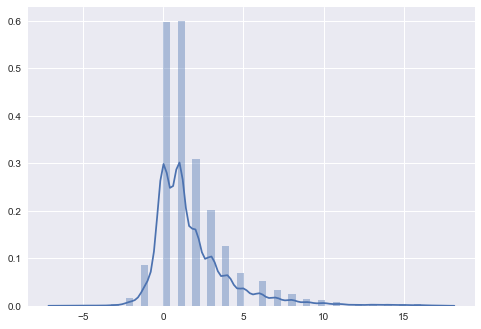

In [8]:
# Removed outliers for visualization purposes
sns.distplot(questions_scores[:int(len(questions_scores)*0.99)])

In [9]:
high_ranked_question_threshold = np.percentile(questions_scores, 90)
high_ranked_question_threshold

5.0

In [10]:
low_ranked_question_threshold = np.percentile(questions_scores, 10)
low_ranked_question_threshold

0.0

## Answers score distribution

In [11]:
answers_scores = sorted(posts_df[(posts_df["post_label"]=="Answer")|(posts_df["post_label"]=="Accepted answer")]["Score"])

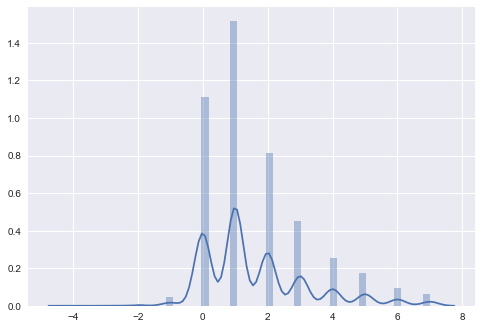

In [12]:
sns.distplot(answers_scores[:int(len(answers_scores)*0.95)])

In [13]:
high_ranked_answers_threshold = np.percentile(answers_scores, 90)
high_ranked_answers_threshold

5.0

In [14]:
low_ranked_answers_threshold = np.percentile(answers_scores, 10)
low_ranked_answers_threshold

0.0

## Label the posts rank

In [15]:
def get_post_rank(post_label,post_score):
    if post_label=="Question":
        if post_score>=high_ranked_question_threshold:
            return "High"
        elif post_score<=low_ranked_question_threshold:
            return "Low"
        else:
            return "Normal"
    else:
        if post_score>=high_ranked_answers_threshold:
            return "High"
        elif post_score<=low_ranked_answers_threshold:
            return "Low"
        else:
            return "Normal"

In [16]:
posts_df["post_rank"] = [get_post_rank(post_label,post_score) for post_label,post_score in zip(posts_df["post_label"],posts_df["Score"])]
posts_df['post_rank'].value_counts()

Normal    11477
Low        5334
High       2257
Name: post_rank, dtype: int64

## Stractural feature extraction

In [17]:
pos_tags = ["CC","CD","DT","EX","FW","IN","JJ","JJR","JJS","LS","MD","NN","NNS","NNP","NNPS","PDT","POS","PRP","PRP$","RB","RBR","RBS","RP","SYM","TO","UH","VB","VBD","VBG","VBN","VBP","VBZ","WDT","WP","WP$","WRB"]

In [18]:
question_feature_names = ["text_length","number_of_links","code_percentage"]
for tag in pos_tags:
    question_feature_names.append("%s_count"%tag)

In [19]:
def extract_stractural_features(df):
    df["text_length"] = df["Body"].map(lambda x: len(x)) + df["Body_Code"].map(lambda x: len(x))
    df["number_of_links"] = df["Body"].map(lambda x: x.count("http://"))
    df["code_percentage"] = df["Body_Code"].map(lambda x: len(x)) / df["text_length"]
    pos_counts = posts_df["Body"].map(lambda body: Counter([x[1] for x in pos_tag(word_tokenize(body))]))
    for tag in pos_tags:
        df["%s_count"%tag] = pos_counts.map(lambda x:x[tag])     

In [20]:
extract_stractural_features(posts_df)

In [21]:
posts_df

,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,CreationDate,FavoriteCount,Id,LastActivityDate,...,VB_count,VBD_count,VBG_count,VBN_count,VBP_count,VBZ_count,WDT_count,WP_count,WP$_count,WRB_count
0,0,1,I've always been interested in machine learnin...,2014-05-14 14:40:25.950,1,1900-01-01 00:00:00.000,2014-05-13 23:58:30.457,1,5,2014-05-14 00:36:31.077,...,9,1,2,2,4,1,0,0,0,3
1,10,3,"As a researcher and instructor, I'm looking fo...",2014-05-14 08:40:54.950,4,1900-01-01 00:00:00.000,2014-05-14 00:11:06.457,1,7,2014-05-16 13:45:00.237,...,1,0,1,0,3,1,2,0,0,0
2,0,0,"Not sure if this fits the scope of this SE, bu...",1900-01-01 00:00:00.000,0,1900-01-01 00:00:00.000,2014-05-14 00:36:31.077,0,9,2014-05-14 00:36:31.077,...,12,2,6,1,6,7,4,2,0,2
3,0,0,"One book that's freely available is ""The Eleme...",1900-01-01 00:00:00.000,1,1900-01-01 00:00:00.000,2014-05-14 00:53:43.273,0,10,2014-05-14 00:53:43.273,...,0,0,1,1,1,6,1,0,0,0
4,29,4,I am sure data science as will be discussed in...,1900-01-01 00:00:00.000,1,1900-01-01 00:00:00.000,2014-05-14 01:25:59.677,4,14,2014-06-20 17:36:05.023,...,3,1,0,2,3,3,0,2,0,1
5,0,0,In which situations would one system be prefer...,2014-05-14 07:41:49.437,1,1900-01-01 00:00:00.000,2014-05-14 01:41:23.110,0,15,2014-05-14 01:41:23.110,...,1,0,0,1,1,0,1,1,0,0
6,46,2,I use Libsvm to train data and predict classif...,1900-01-01 00:00:00.000,0,1900-01-01 00:00:00.000,2014-05-14 01:57:56.880,0,16,2014-05-17 16:24:14.523,...,4,2,0,0,2,2,1,0,0,0
7,0,0,LIBSVM is a library for support vector classif...,1900-01-01 00:00:00.000,0,1900-01-01 00:00:00.000,2014-05-14 02:49:14.580,0,17,2014-05-16 13:44:53.470,...,0,1,0,1,0,1,0,0,0,0
9,37,12,Lots of people use the term big data in a rath...,1900-01-01 00:00:00.000,5,1900-01-01 00:00:00.000,2014-05-14 03:56:20.963,16,19,2016-11-25 22:34:51.253,...,4,1,1,3,4,4,0,1,0,1
10,26,5,we created this social network application for...,1900-01-01 00:00:00.000,1,1900-01-01 00:00:00.000,2014-05-14 05:37:46.780,1,20,2017-08-29 11:26:37.137,...,1,1,3,3,2,6,0,0,0,1


In [23]:
def extract_answer_only_stractural_features(posts_df):
    question_answers_join = pd.merge(posts_df, posts_df,  how='left', left_on=['Id'], right_on = ['ParentId'])
    posts_df["text_length_ratio"] = question_answers_join.apply(lambda x: x["text_length_x"]/x["text_length_y"],axis=1)
    posts_df["code_length_ratio"] = question_answers_join.apply(lambda x: 0 if ((x["Body_Code_y"] is np.nan) or (len(x["Body_Code_x"])==0) or (len(x["Body_Code_y"]))==0) else len(x["Body_Code_x"])/len(x["Body_Code_y"]),axis=1)
    posts_df["response_time_difference"] = question_answers_join.apply(lambda x: (x["CreationDate_y"]-x["CreationDate_x"]).total_seconds(),axis=1)
    posts_df["response_time_difference"] = posts_df["response_time_difference"].apply(lambda x: x if np.isnan(x) else int(x))

In [24]:
extract_answer_only_stractural_features(posts_df)

## Complicated features

In [26]:
vectorizer = TfidfVectorizer(sublinear_tf=True,
                                 stop_words='english',analyzer='word')
tf = vectorizer.fit_transform(posts_df["Body"])
posts_df["tf_idf"] = [x for x in tf.toarray()]

In [27]:
number_of_topics = 150
posts_df["Tags"] = posts_df["Tags"].map(lambda x: [] if (x is np.nan) else x.replace("<","").replace(">",",").strip(",").split(","))
tags = reduce(lambda x,y: x+y,posts_df["Tags"])
tags_freq = Counter(tags)
print(tags_freq.most_common(number_of_topics))

[('machine-learning', 2854), ('python', 1253), ('neural-network', 1168), ('deep-learning', 882), ('classification', 867), ('r', 711), ('data-mining', 613), ('scikit-learn', 505), ('nlp', 486), ('clustering', 443), ('predictive-modeling', 436), ('dataset', 413), ('keras', 378), ('time-series', 353), ('tensorflow', 344), ('regression', 339), ('text-mining', 316), ('statistics', 305), ('bigdata', 285), ('feature-selection', 236), ('visualization', 235), ('convnet', 217), ('random-forest', 214), ('pandas', 210), ('algorithms', 208), ('svm', 201), ('data-cleaning', 196), ('logistic-regression', 188), ('decision-trees', 181), ('data', 178), ('recommender-system', 165), ('xgboost', 157), ('linear-regression', 156), ('rnn', 152), ('apache-spark', 150), ('feature-extraction', 149), ('image-classification', 147), ('k-means', 126), ('cross-validation', 121), ('reinforcement-learning', 113), ('optimization', 110), ('multiclass-classification', 110), ('feature-engineering', 110), ('gradient-descent

In [28]:
topics_indexes = {x[0]:index for index,x in enumerate(tags_freq.most_common(number_of_topics))}

In [29]:
def get_topic_labels(x):
    labels = np.zeros(len(topics_indexes))
    indexes = []
    for topic in x:
        if topic in topics_indexes:
            indexes.append(topics_indexes[topic])
    labels[indexes] = 1
    return labels
posts_df["topics_labels"] = posts_df["Tags"].map(get_topic_labels)

In [30]:
def post_to_filtered_word_vector(post):
    return [word for word in word_tokenize(post.lower()) if word not in stopwords.words('english')]

In [31]:
def create_dictionary(post_body):
    body_vectors_filtered=[post_to_filtered_word_vector(body) for body in tqdm(post_body)]
    dictionary = corpora.Dictionary(body_vectors_filtered)
    return dictionary,body_vectors_filtered

In [32]:
dictionary,posts_words_vectors = create_dictionary(posts_df["Body"])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19068/19068 [18:56<00:00, 16.77it/s]
INFO : adding document #0 to Dictionary(0 unique tokens: [])
INFO : adding document #10000 to Dictionary(58260 unique tokens: ["'ve", 'always', 'interested', 'machine', 'learning']...)
INFO : built Dictionary(101024 unique tokens: ["'ve", 'always', 'interested', 'machine', 'learning']...) from 19068 documents (total 2271292 corpus positions)


In [33]:
def train_lda(dictionary,posts_words_vectors,number_of_topics):
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in tqdm(posts_words_vectors)]
    return gensim.models.ldamodel.LdaModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary, passes=10)

In [34]:
ldamodel = train_lda(dictionary,posts_words_vectors,number_of_topics)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19068/19068 [00:02<00:00, 7674.31it/s]
INFO : using symmetric alpha at 0.006666666666666667
INFO : using symmetric eta at 9.898637947418435e-06
INFO : using serial LDA version on this node
INFO : running online (multi-pass) LDA training, 150 topics, 10 passes over the supplied corpus of 19068 documents, updating model once every 2000 documents, evaluating perplexity every 19068 documents, iterating 50x with a convergence threshold of 0.001000
INFO : PROGRESS: pass 0, at document #2000/19068
INFO : merging changes from 2000 documents into a model of 19068 documents
INFO : topic #22 (0.007): 0.055*"," + 0.039*"." + 0.031*":" + 0.023*"data" + 0.020*"(" + 0.017*")" + 0.009*"http" + 0.006*"also" + 0.006*"value" + 0.006*"n't"
INFO : topic #39 (0.007): 0.075*"," + 0.041*":" + 0.030*"." + 0.016*"(" + 0.016*"?

INFO : topic #29 (0.007): 0.126*"cnn" + 0.036*"." + 0.033*"comments" + 0.027*"," + 0.025*"cnns" + 0.022*"adam" + 0.021*"hierarchical" + 0.018*"pixels" + 0.018*"80" + 0.014*"image"
INFO : topic #44 (0.007): 0.099*"." + 0.051*"," + 0.015*"pooling" + 0.011*")" + 0.010*"(" + 0.008*"one" + 0.007*":" + 0.007*"?" + 0.006*"removed" + 0.005*"finds"
INFO : topic #81 (0.007): 0.066*"," + 0.046*"." + 0.021*"0.0" + 0.020*"beta" + 0.018*")" + 0.015*"(" + 0.010*"4.0" + 0.009*"3.0" + 0.008*"data" + 0.008*"?"
INFO : topic diff=3.132147, rho=0.353553
INFO : PROGRESS: pass 0, at document #18000/19068
INFO : merging changes from 2000 documents into a model of 19068 documents
INFO : topic #19 (0.007): 0.069*"scores" + 0.046*"orange" + 0.025*"." + 0.021*"," + 0.021*"patient" + 0.016*"showing" + 0.015*"learner" + 0.015*"widget" + 0.013*"data" + 0.013*"importance"
INFO : topic #70 (0.007): 0.053*"predictions" + 0.045*"precision" + 0.042*"recall" + 0.041*"predicted" + 0.029*"u" + 0.023*"." + 0.023*")" + 0.021*

INFO : topic #31 (0.007): 0.111*"points" + 0.042*"k-means" + 0.042*"." + 0.037*"v" + 0.034*"embedding" + 0.031*"," + 0.029*"point" + 0.025*"initial" + 0.016*"squared" + 0.015*")"
INFO : topic #52 (0.007): 0.028*"solved" + 0.028*"mapping" + 0.025*"phrase" + 0.024*"ids" + 0.022*"poisson" + 0.022*"–" + 0.021*"ordered" + 0.021*"cc" + 0.016*"meet" + 0.011*"."
INFO : topic #86 (0.007): 0.076*"regularization" + 0.044*"obtained" + 0.038*"iris" + 0.036*"round" + 0.031*"matlab" + 0.023*"species" + 0.019*"indicating" + 0.015*"stopping" + 0.015*"capability" + 0.012*"pointers"
INFO : topic #83 (0.007): 0.175*"data" + 0.047*"science" + 0.046*"." + 0.028*"," + 0.028*"?" + 0.027*"question" + 0.017*"questions" + 0.015*"statistics" + 0.015*"scientist" + 0.014*"answer"
INFO : topic #133 (0.007): 0.050*"." + 0.044*"label" + 0.042*"," + 0.035*"text" + 0.034*")" + 0.031*"(" + 0.027*"labels" + 0.026*"documents" + 0.019*"document" + 0.018*"tf-idf"
INFO : topic diff=1.158642, rho=0.294449
INFO : PROGRESS: pass

INFO : topic #126 (0.007): 0.088*"." + 0.071*"layer" + 0.047*"weights" + 0.038*"output" + 0.033*"input" + 0.032*"," + 0.023*"layers" + 0.022*"hidden" + 0.021*"network" + 0.017*")"
INFO : topic #33 (0.007): 0.050*"(" + 0.048*"model.add" + 0.045*")" + 0.028*"," + 0.022*"model" + 0.017*"activation='relu" + 0.012*"shape=" + 0.011*"32" + 0.009*"padding='same" + 0.009*"model.compile"
INFO : topic #40 (0.007): 0.084*"index" + 0.074*"net" + 0.038*"visualize" + 0.034*"join" + 0.031*"500" + 0.024*"million" + 0.020*"." + 0.018*"gini" + 0.016*"failure" + 0.016*"lasso"
INFO : topic diff=0.460187, rho=0.282459
INFO : PROGRESS: pass 2, at document #8000/19068
INFO : merging changes from 2000 documents into a model of 19068 documents
INFO : topic #47 (0.007): 0.134*"classifier" + 0.075*"topic" + 0.073*"classifiers" + 0.042*"ensemble" + 0.026*"characters" + 0.023*"modeling" + 0.021*"." + 0.018*"abstract" + 0.018*"topics" + 0.015*"recognize"
INFO : topic #148 (0.007): 0.023*"self" + 0.019*"," + 0.017*")

INFO : topic #54 (0.007): 0.098*"." + 0.075*"," + 0.053*"model" + 0.034*"models" + 0.030*"accuracy" + 0.022*"data" + 0.020*"using" + 0.020*"results" + 0.017*"different" + 0.016*"best"
INFO : topic diff=0.147733, rho=0.282459
INFO : PROGRESS: pass 3, at document #2000/19068
INFO : merging changes from 2000 documents into a model of 19068 documents
INFO : topic #29 (0.007): 0.170*"cnn" + 0.068*"comments" + 0.051*"hierarchical" + 0.030*"adam" + 0.027*"cnns" + 0.022*"learners" + 0.019*"svms" + 0.016*"occurrences" + 0.016*"light" + 0.014*"sub"
INFO : topic #48 (0.007): 0.205*"model" + 0.130*"regression" + 0.074*"linear" + 0.056*"." + 0.043*"models" + 0.039*"logistic" + 0.027*"," + 0.024*"parameters" + 0.015*"coefficients" + 0.013*"use"
INFO : topic #116 (0.007): 0.085*"id" + 0.078*"na" + 0.060*"pass" + 0.037*"0.25" + 0.023*"docs" + 0.019*"ab" + 0.015*"intersection" + 0.012*"ads" + 0.009*"0.75" + 0.008*"22"
INFO : topic #24 (0.007): 0.058*"normalization" + 0.055*"frame" + 0.042*"dataframe" +

INFO : topic #36 (0.007): 0.062*"filter" + 0.061*"convolution" + 0.055*"encoding" + 0.044*"filters" + 0.030*"strings" + 0.029*"hot" + 0.029*"one-hot" + 0.025*"encode" + 0.022*"," + 0.019*"."
INFO : topic #101 (0.007): 0.105*"relu" + 0.026*"games" + 0.022*"shuffle" + 0.021*"vanishing" + 0.019*"im" + 0.018*"play" + 0.015*"." + 0.014*"love" + 0.012*"," + 0.012*"pp"
INFO : topic #109 (0.007): 0.080*"50" + 0.070*"20" + 0.055*"30" + 0.045*"1." + 0.041*"2." + 0.037*"100" + 0.031*"biases" + 0.028*"80" + 0.025*"10" + 0.020*"90"
INFO : topic #14 (0.007): 0.054*"." + 0.022*"quality" + 0.021*"?" + 0.020*"data" + 0.020*"new" + 0.014*"tool" + 0.014*"mode" + 0.014*"dataset" + 0.014*"steps" + 0.013*"know"
INFO : topic #54 (0.007): 0.094*"." + 0.075*"," + 0.058*"model" + 0.038*"models" + 0.031*"accuracy" + 0.021*"results" + 0.021*"using" + 0.020*"data" + 0.019*"different" + 0.018*"best"
INFO : topic diff=0.073481, rho=0.271823
INFO : PROGRESS: pass 3, at document #18000/19068
INFO : merging changes fro

INFO : topic #116 (0.007): 0.145*"na" + 0.123*"id" + 0.051*"pass" + 0.025*"docs" + 0.022*"0.25" + 0.019*"intersection" + 0.016*"ab" + 0.012*"22" + 0.010*"houses" + 0.009*"notation"
INFO : topic #43 (0.007): 0.126*"df" + 0.091*"import" + 0.054*"int" + 0.049*"pandas" + 0.021*"optimizer" + 0.014*"matplotlib" + 0.014*"url" + 0.013*"latitude" + 0.013*"longitude" + 0.009*"directed"
INFO : topic #59 (0.007): 0.093*"data" + 0.089*"training" + 0.074*"set" + 0.070*"." + 0.057*"test" + 0.042*"model" + 0.039*"," + 0.038*"train" + 0.030*"dataset" + 0.017*"validation"
INFO : topic #36 (0.007): 0.067*"filter" + 0.051*"convolution" + 0.049*"encoding" + 0.042*"filters" + 0.035*"strings" + 0.030*"encode" + 0.026*"one-hot" + 0.023*"hot" + 0.021*"padding" + 0.020*"hash"
INFO : topic diff=0.056917, rho=0.262306
INFO : PROGRESS: pass 4, at document #12000/19068
INFO : merging changes from 2000 documents into a model of 19068 documents
INFO : topic #31 (0.007): 0.202*"points" + 0.078*"point" + 0.072*"k-means

INFO : topic #63 (0.007): 0.087*"-1" + 0.074*"numbers" + 0.060*"rank" + 0.057*"sequences" + 0.044*"ranking" + 0.036*"+1" + 0.033*"students" + 0.025*"percentage" + 0.024*"covariance" + 0.022*"11"
INFO : topic #88 (0.007): 0.147*"select" + 0.026*"zeros" + 0.026*"pd.dataframe" + 0.023*"bagging" + 0.022*"union" + 0.021*"timestamp" + 0.021*"jupyter" + 0.018*"interests" + 0.018*"device" + 0.014*"layout"
INFO : topic diff=0.077917, rho=0.253722
INFO : PROGRESS: pass 5, at document #6000/19068
INFO : merging changes from 2000 documents into a model of 19068 documents
INFO : topic #34 (0.007): 0.144*"r" + 0.068*"python" + 0.054*"package" + 0.049*"." + 0.039*":" + 0.033*"code" + 0.027*"link" + 0.026*"source" + 0.025*"packages" + 0.020*"library"
INFO : topic #62 (0.007): 0.082*"helps" + 0.057*"hope" + 0.041*"folds" + 0.037*"generator" + 0.027*"fold" + 0.026*"profile" + 0.025*"partition" + 0.019*"99" + 0.019*"k-fold" + 0.017*"trivial"
INFO : topic #33 (0.007): 0.050*"model.add" + 0.042*"(" + 0.038

INFO : -7.234 per-word bound, 150.5 perplexity estimate based on a held-out corpus of 1068 documents with 135451 words
INFO : PROGRESS: pass 5, at document #19068/19068
INFO : merging changes from 1068 documents into a model of 19068 documents
INFO : topic #57 (0.007): 0.052*"save" + 0.041*"dictionary" + 0.032*"movie" + 0.031*"t-sne" + 0.030*"et" + 0.026*"." + 0.023*"al" + 0.020*"saved" + 0.017*"loading" + 0.016*"movies"
INFO : topic #46 (0.007): 0.031*"fill" + 0.028*"draw" + 0.027*"transaction" + 0.027*"patients" + 0.027*"empty" + 0.026*"transactions" + 0.023*"disease" + 0.020*"relevance" + 0.019*"opencv" + 0.018*"occurrence"
INFO : topic #128 (0.007): 0.326*")" + 0.323*"(" + 0.096*"=" + 0.046*"," + 0.035*":" + 0.025*"x" + 0.013*"+" + 0.011*"*" + 0.007*"1" + 0.006*"code"
INFO : topic #146 (0.007): 0.337*"b" + 0.142*"target" + 0.038*"f" + 0.032*"max" + 0.014*"3rd" + 0.014*"2nd" + 0.014*"returns" + 0.011*"train_data" + 0.009*"xy" + 0.008*"c."
INFO : topic #28 (0.007): 0.052*"." + 0.048*

INFO : topic #76 (0.007): 0.268*"function" + 0.107*"activation" + 0.059*"functions" + 0.028*"sigmoid" + 0.015*"," + 0.014*"perceptron" + 0.014*"." + 0.013*"sensor" + 0.011*"ahead" + 0.010*"combination"
INFO : topic #20 (0.007): 0.093*"nan" + 0.080*"0." + 0.039*"zero" + 0.034*"dot" + 0.028*"chain" + 0.024*"entries" + 0.021*"product" + 0.017*"d2" + 0.016*"w.r.t" + 0.014*"occurred"
INFO : topic #80 (0.007): 0.090*"batch" + 0.055*"x_train" + 0.044*"y_train" + 0.042*"x_test" + 0.029*"y_test" + 0.022*"parameter" + 0.022*"import" + 0.017*"train_test_split" + 0.016*"delta" + 0.012*"regularisation"
INFO : topic #8 (0.007): 0.405*";" + 0.279*"&" + 0.104*"gt" + 0.097*"lt" + 0.004*"," + 0.004*")" + 0.004*"(" + 0.003*":" + 0.002*"." + 0.002*"mutate"
INFO : topic diff=0.051359, rho=0.245930
INFO : PROGRESS: pass 6, at document #16000/19068
INFO : merging changes from 2000 documents into a model of 19068 documents
INFO : topic #39 (0.007): 0.176*"name" + 0.060*"names" + 0.037*"report" + 0.030*"addres

INFO : topic #146 (0.007): 0.335*"b" + 0.130*"target" + 0.041*"f" + 0.024*"max" + 0.017*"2nd" + 0.013*"returns" + 0.011*"3rd" + 0.010*"c." + 0.009*"xy" + 0.008*"versus"
INFO : topic #80 (0.007): 0.075*"batch" + 0.062*"x_train" + 0.049*"y_train" + 0.045*"x_test" + 0.032*"y_test" + 0.029*"import" + 0.018*"train_test_split" + 0.017*"parameter" + 0.015*"delta" + 0.012*"regularisation"
INFO : topic #0 (0.007): 0.475*"''" + 0.307*"``" + 0.086*"," + 0.034*":" + 0.006*"null" + 0.005*"type" + 0.005*"true" + 0.004*"(" + 0.004*")" + 0.002*"."
INFO : topic diff=0.051771, rho=0.238814
INFO : PROGRESS: pass 7, at document #10000/19068
INFO : merging changes from 2000 documents into a model of 19068 documents
INFO : topic #21 (0.007): 0.119*"new" + 0.107*"array" + 0.082*"string" + 0.051*"key" + 0.044*"double" + 0.026*"//" + 0.018*"init" + 0.017*"public" + 0.016*"token" + 0.016*"boolean"
INFO : topic #47 (0.007): 0.291*"classifier" + 0.080*"classifiers" + 0.053*"topic" + 0.044*"ensemble" + 0.021*"mode

INFO : topic #11 (0.007): 0.527*"#" + 0.062*"=" + 0.022*"import" + 0.022*"val" + 0.015*"z" + 0.014*"," + 0.013*"(" + 0.012*")" + 0.009*"print" + 0.007*"create"
INFO : topic #110 (0.007): 0.048*"cat" + 0.041*"time-series" + 0.033*"dynamic" + 0.020*"records" + 0.018*"noticed" + 0.017*"request" + 0.017*"dtw" + 0.015*"cons" + 0.015*"anywhere" + 0.015*"pros"
INFO : topic diff=0.094762, rho=0.232282
INFO : PROGRESS: pass 8, at document #4000/19068
INFO : merging changes from 2000 documents into a model of 19068 documents
INFO : topic #122 (0.007): 0.171*"5" + 0.107*"4" + 0.097*"6" + 0.083*"7" + 0.079*"8" + 0.062*"9" + 0.043*"3" + 0.039*"12" + 0.013*"2" + 0.012*"24"
INFO : topic #10 (0.007): 0.159*"state" + 0.074*"straight" + 0.043*"forward" + 0.043*"transform" + 0.036*"good" + 0.029*"center" + 0.024*"phase" + 0.023*"bad" + 0.022*"operations" + 0.020*"direct"
INFO : topic #136 (0.007): 0.035*"segmentation" + 0.035*"'a" + 0.026*"correctly" + 0.026*"'b" + 0.023*"'c" + 0.021*"quantity" + 0.018*"

INFO : topic #22 (0.007): 0.260*"variables" + 0.205*"variable" + 0.107*"categorical" + 0.043*"dependent" + 0.032*"independent" + 0.017*"ordinal" + 0.017*"files" + 0.016*"relationship" + 0.013*"nominal" + 0.009*"whose"
INFO : topic diff=0.047459, rho=0.232282
INFO : PROGRESS: pass 8, at document #18000/19068
INFO : merging changes from 2000 documents into a model of 19068 documents
INFO : topic #110 (0.007): 0.046*"cat" + 0.041*"time-series" + 0.035*"dynamic" + 0.023*"records" + 0.020*"noticed" + 0.017*"request" + 0.016*"pyspark" + 0.016*"dtw" + 0.015*"cons" + 0.015*"anywhere"
INFO : topic #102 (0.007): 0.543*"'" + 0.048*"(" + 0.048*")" + 0.034*"," + 0.030*":" + 0.020*"=" + 0.012*"import" + 0.011*"print" + 0.011*"batch_size" + 0.006*"["
INFO : topic #37 (0.007): 0.314*"time" + 0.128*"series" + 0.036*"window" + 0.015*"." + 0.013*"temporal" + 0.012*"degrees" + 0.011*"forecasting" + 0.011*"length" + 0.009*"measured" + 0.008*"trend"
INFO : topic #112 (0.007): 0.033*"median" + 0.031*"blood" 

INFO : topic #116 (0.007): 0.124*"id" + 0.118*"na" + 0.057*"pass" + 0.020*"docs" + 0.019*"0.25" + 0.016*"intersection" + 0.014*"22" + 0.013*"ab" + 0.010*"physical" + 0.010*"plotted"
INFO : topic #95 (0.007): 0.223*"distance" + 0.061*"metric" + 0.041*"euclidean" + 0.026*"l2" + 0.022*"l1" + 0.021*"paragraph" + 0.021*"metrics" + 0.018*"detect" + 0.015*"two" + 0.015*"calculating"
INFO : topic #3 (0.007): 0.195*"system" + 0.067*"recommendation" + 0.047*"systems" + 0.034*"recommender" + 0.034*"recommendations" + 0.030*"content" + 0.023*"engine" + 0.022*"apple" + 0.019*"creates" + 0.019*"translation"
INFO : topic #96 (0.007): 0.076*"." + 0.066*"," + 0.021*"standard" + 0.020*"continuous" + 0.020*"data" + 0.012*"measure" + 0.012*")" + 0.011*"(" + 0.011*"outcome" + 0.010*"methods"
INFO : topic #88 (0.007): 0.172*"select" + 0.035*"pd.dataframe" + 0.035*"zeros" + 0.029*"timestamp" + 0.028*"bagging" + 0.024*"jupyter" + 0.020*"device" + 0.016*"union" + 0.013*"selecting" + 0.012*"persons"
INFO : topi

In [35]:
ldamodel.save("lda.model")

INFO : saving LdaState object under lda.model.state, separately None
INFO : storing np array 'sstats' to lda.model.state.sstats.npy
INFO : saved lda.model.state
INFO : saving LdaModel object under lda.model, separately ['expElogbeta', 'sstats']
INFO : storing np array 'expElogbeta' to lda.model.expElogbeta.npy
INFO : not storing attribute id2word
INFO : not storing attribute state
INFO : not storing attribute dispatcher
INFO : saved lda.model


In [36]:
def KL(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)
    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

In [37]:
def smoothed_hist_kl_distance(a, b, nbins=10, sigma=1):
    ahist, bhist = (np.histogram(a, bins=nbins)[0],
                    np.histogram(b, bins=nbins)[0])

    asmooth, bsmooth = (gaussian_filter(ahist, sigma),
                        gaussian_filter(bhist, sigma))

    return KL(asmooth, bsmooth)

In [38]:
def topic_dist_to_arr(topic_dist):
    dist_1_arr = np.zeros(number_of_topics)
    dist_1_arr[[x[0] for x in topic_dist]]=[x[1] for x in topic_dist]
    return dist_1_arr

In [39]:
def calc_kld(topic_dist_1, topic_dist_2):
    if topic_dist_1 is None or topic_dist_1 is np.nan or topic_dist_2 is None or topic_dist_2 is np.nan:
        return -1.0
    dist_1_arr = topic_dist_to_arr(topic_dist_1)
    dist_2_arr = topic_dist_to_arr(topic_dist_2)
    return smoothed_hist_kl_distance(dist_1_arr,dist_2_arr)

In [40]:
def extract_topic_discribution_features(ldamodel,dictionary,posts_words_vectors):
    posts_df["topics_dist"] = [ldamodel[dictionary.doc2bow(post_words_vector)] for post_words_vector in tqdm(posts_words_vectors)]
    question_answers_join = pd.merge(posts_df, posts_df,  how='inner', left_on=['Id'], right_on = ['ParentId'])
    answers_indexes = question_answers_join["Id_y"].values
    kld_values = question_answers_join.apply(lambda x: calc_kld(x["topics_dist_x"],x["topics_dist_y"]),axis=1)
    tf_idf_similarity_values = question_answers_join.apply(lambda x: cosine_similarity(x["tf_idf_x"].reshape(1, -1),x["tf_idf_y"].reshape(1, -1))[0][0],axis=1)
    posts_df["kld"] = -1
    posts_df["tf_idf_similarity"] = -1
    for i,index in enumerate(tqdm(answers_indexes)):
        posts_df.loc[posts_df.Id==index,"kld"]=kld_values[i]
        posts_df.loc[posts_df.Id==index,"tf_idf_similarity"]=tf_idf_similarity_values[i]
    for topic_id in range(number_of_topics):
        posts_df["topic_dist_%s"%topic_id] = 0.0
    for index,topic_dist in enumerate(tqdm(posts_df["topics_dist"])):
        for topic,value in topic_dist:
            posts_df.iloc[index,posts_df.columns.get_loc("topic_dist_%s"%topic)]=value
    del question_answers_join
    del posts_df["topics_dist"]
    del posts_df["tf_idf"]

In [41]:
extract_topic_discribution_features(ldamodel,dictionary,posts_words_vectors)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19068/19068 [01:31<00:00, 209.35it/s]
C:\Users\Ofri\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\Ofri\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\Ofri\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.
C:\Users\Ofri\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

# Create user related features

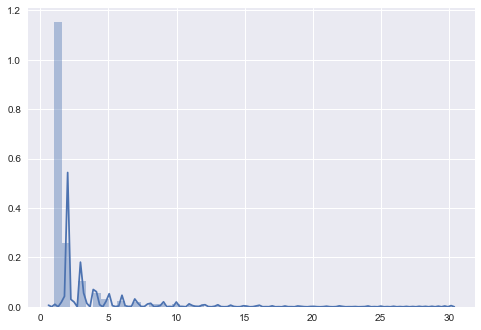

In [42]:
post_to_user_map = {k:v for k,v in zip(posts_df['Id'],posts_df['OwnerUserId'])}
user_to_num_of_posts_map = Counter(list(post_to_user_map.values()))
post_counts=sorted(list(user_to_num_of_posts_map.values()))
sns.distplot(post_counts[:int(len(post_counts)*0.99)])

## Calculate number of posts per user (prior to the given post)

In [43]:
user_to_number_of_posts_map={}
user_number_of_past_posts=[]
for index,row in posts_df.sort_values('CreationDate').iterrows():
    user_id = row['OwnerUserId']
    if user_id not in user_to_number_of_posts_map:
        user_to_number_of_posts_map[user_id] = 1
        user_number_of_past_posts.append(0)
    else:
        user_number_of_past_posts.append(user_to_num_of_posts_map[user_id])
        user_to_num_of_posts_map[user_id] += 1
posts_df['number_of_past_user_posts'] = user_number_of_past_posts

## Calculate number of accepted answers per user (prior to the given post)

In [44]:
user_to_number_of_accepted_answers_map={}
l=[]
for index,row in posts_df.sort_values('CreationDate').iterrows():
    user_id = row['OwnerUserId']
    if user_id not in user_to_number_of_accepted_answers_map:
        l.append(0)
    else:
        l.append(user_to_number_of_accepted_answers_map[user_id])
    if row['post_label'] == 'Accepted answer':
        if user_id not in user_to_number_of_accepted_answers_map:
            user_to_number_of_accepted_answers_map[user_id] = 0
        user_to_number_of_accepted_answers_map[user_id]+=1
posts_df['number_of_past_accepted_answers'] = l

## Calculate user degrees
* Degrees are number of users that the given user has communicated with

In [45]:
g = nx.Graph()
for index,row in posts_df[posts_df['post_label']!='Question'].iterrows():
    try:
        g.add_edge(row['OwnerUserId'],post_to_user_map[row['ParentId']])
    except:
        pass

nodes_degrees={}
for n in g.nodes():
    nodes_degrees[n] = g.degree(n)
degrees=[]
for user_id in posts_df['OwnerUserId']:
    try:
        degrees.append(nodes_degrees[user_id])
    except:
        degrees.append(0)
posts_df['user_degree']=degrees

## Calculate node betweeness

In [46]:
graph_betweeness = nx.betweenness_centrality(g)

In [47]:
betweeness=[]
for user_id in posts_df['OwnerUserId']:
    try:
        betweeness.append(graph_betweeness[user_id])
    except:
        betweeness.append(0)
posts_df['betweeness'] = betweeness

## find whether a user is a member of a certain clique

In [48]:
clique_members=[]
for clique in nx.find_cliques(g):
    if len(clique)>2:
        clique_members.extend(clique)
clique_members=list(set(clique_members))
is_clique_member=[]
for u_id in posts_df['OwnerUserId']:
    if u_id in clique_members:
        is_clique_member.append(1)
    else:
        is_clique_member.append(0)
posts_df['is_clique_member'] = is_clique_member

In [49]:
posts_df.to_csv("dataset_and_features.csv",encoding="utf8",index=False)

In [82]:
topics_data = []
for i in range(number_of_topics):
    topics_data.append([i]+[x[0] for x in ldamodel.show_topic(i)]+[x[1] for x in ldamodel.show_topic(i)])
topics_df = pd.DataFrame(topics_data,columns=["topic_id"]+["word_%s"%i for i in range(10)]+["word_%s_weight"%i for i in range(10)])

In [83]:
topics_df.to_csv("topics_words.csv",encoding="utf8",index=False)